# 4 - Rede neural de muitas camadas

Nosso objetivo é usar redes neurais para gerar algo que se parece com português. Mais especificamente, algo que se pareça com um português específico --- aquele usado por Machado de Assis.

O código desse notebook é adaptado do repositório `nn-zero-to-hero`, de Andrej Karpathy. Os notebooks correspondentes (em inglês) podem ser encontrados na seguinte URL: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/.

-------------------------------

Munidos das camadas de normalização, vamos criar uma rede com muitas camadas escondidas sem que o gradiente se dissipe ou exploda.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

with open("../data/gpt/processed/machado-all.txt", "r") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: entra string, saem inteiros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: entram inteiros, sai uma string

data = text

block_size = 3

def build_dataset(data):  
    X, Y = [], []
    context = [0] * block_size
    for ch in data:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

## 4.1 Organizando o código

Vamos começar a seguir algumas convenções do pacote PyTorch, de tal maneira que nosso código comece a se aproximar do que faremos na prática ao treinar redes neurais. Em primeiro lugar, vamos evitar replicar o código de várias camadas e ao invés utilizar classes de camadas que podem ser instanciadas múltiplas vezes.

In [2]:
class Linear:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [3]:
class BatchNorm1d:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parâmetros (treinados via backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (valores correntes para média e variância dos batches)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update dos buffers (apenas durante o treino )
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

In [4]:
class Tanh:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

Com isso, nosso código passa a ficar muito mais simples.

A princípio, vamos considerar apenas blocos de camadas linear + tanh e estudaremos alguns diagnósticos importantes de redes neurais. Depois, adicionaremos batchnorm para entender seu efeito nos diagnósticos. Por ora, nossa rede é a seguinte:

In [5]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

# Agora, vamos usar vários blocos de camadas (linear + batchnorm + tanh):
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

In [6]:
with torch.no_grad():
    # Vamos inicializar a última camada com escala baixa, para evitar uma perda inicial ruim
    layers[-1].weight *= 0.1
    # Como estamos usando tanh, inicializamos os pesos com um fator extra de 5/3
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Número de parâmetros: {sum(p.nelement() for p in parameters)}") # Número de parâmetros
for p in parameters:
    p.requires_grad = True

Número de parâmetros: 48162


Vamos ter certeza de que tudo roda como deveria.

In [7]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: ir além dessa primeira iteração!

      0/ 100000: 3.7339


Vamos investigar como estão os forward e backward passes nessas primeiras iterações.

Layer 1 (Tanh): mean -0.03, std 0.76, saturation 19.88%
Layer 3 (Tanh): mean -0.00, std 0.69, saturation 9.69%
Layer 5 (Tanh): mean -0.00, std 0.67, saturation 6.25%
Layer 7 (Tanh): mean 0.01, std 0.67, saturation 5.75%
Layer 9 (Tanh): mean 0.05, std 0.66, saturation 5.59%


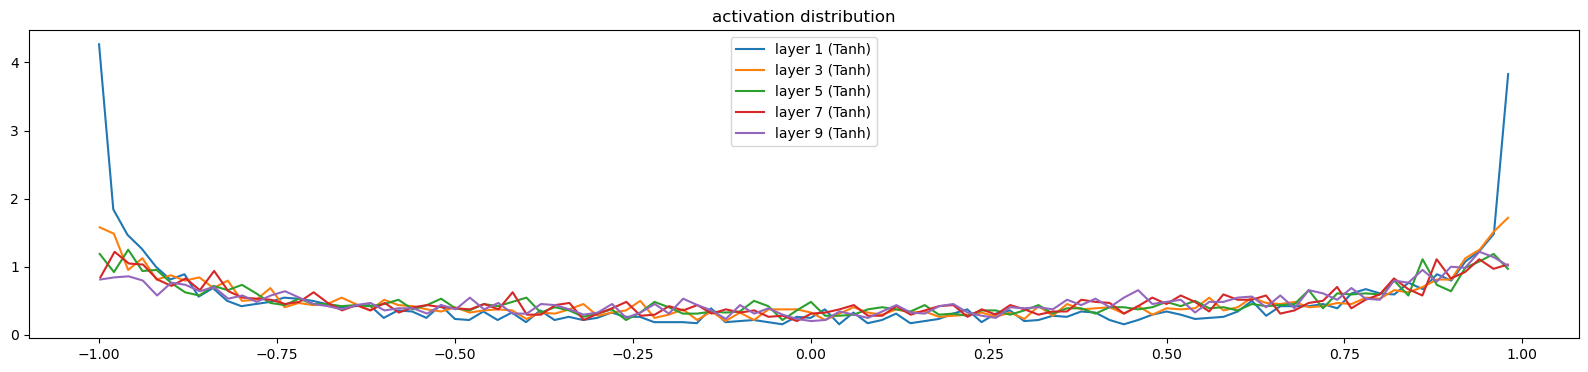

In [8]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
    
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.mean()
        layer_std = layer.out.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution');

Ou seja, ao final da primeira época, quase 20% dos pesos da primeira camada de tanh esteve acima de 0.97 em valor absoluto. Esses são pesos que acabam transmitindo pouca informação num update de gradiente. Mesmo assim, nas outras camadas há uma certa convergência de comportamento; isso é porque inicializamos as camadas lineares com $(5/3)\cdot(1/\sqrt{\text{fan}_{\text{in}}})$.

Se replicarmos o experimento acima, mas com inicialização $(1/2) \cdot (1/\sqrt{\text{fan}_{\text{in}}})$, teríamos um problema de ativição dissipada.

48162
      0/ 100000: 3.7376
Layer 1 (Tanh): mean -0.02, std 0.41, saturation 0.03%
Layer 3 (Tanh): mean 0.00, std 0.20, saturation 0.00%
Layer 5 (Tanh): mean -0.00, std 0.10, saturation 0.00%
Layer 7 (Tanh): mean 0.00, std 0.05, saturation 0.00%
Layer 9 (Tanh): mean 0.00, std 0.02, saturation 0.00%


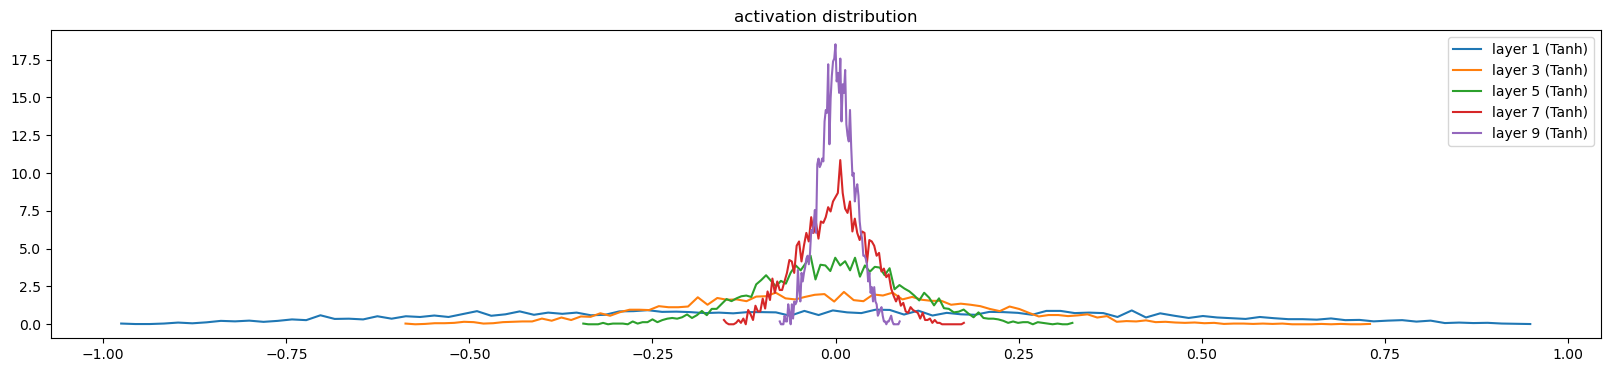

In [9]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # --------------------------------------------------------
            layer.weight *= 0.5
            # --------------------------------------------------------

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: ir além dessa primeira iteração!

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
    
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.mean()
        layer_std = layer.out.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution');

De fato, note que a média permanece em zero, mas o desvio-padrão está lentamente sendo reduzido. Isso é porque a ativação tanh está comprimindo os resultados da camada linear de $\mathbb{R}$ para $[-1, 1]$.

Se por um lado a inicialização com 1/2 é muito pequena (versus 5/3), algo maior, como 5, deveria resultar no problema oposto: ativações explosivas. Faça as alterações necessárias acima e veja o resultado re-gerando a célula.

## 4.2 Diagnóstico: backward pass

O problema de ter ativações saturadas é que os gradientes correspondentes são essencialmente zero, e o aprendizado fica estancado. Isso pode ser visto diretamente analisando o histograma dos gradientes em cada camada. Note que, a depender da inicialização em 5/3, 5 ou 0.5, temos gradientes estabilizados, dissipados ou explosivos.

48162
      0/ 100000: 3.7339
Layer 1 (Tanh): mean 0.000010, std 0.000401, 
Layer 3 (Tanh): mean 0.000002, std 0.000374, 
Layer 5 (Tanh): mean -0.000000, std 0.000348, 
Layer 7 (Tanh): mean 0.000010, std 0.000320, 
Layer 9 (Tanh): mean 0.000007, std 0.000303, 


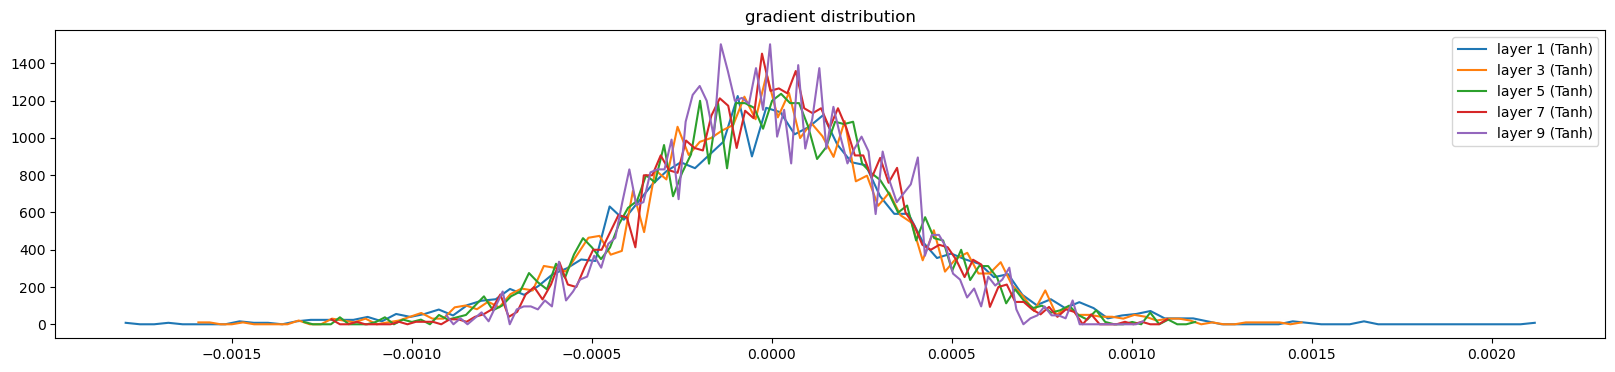

In [10]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # --------------------------------------------------------
            layer.weight *= 5/3 # 5 # 0.5
            # --------------------------------------------------------

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: ir além dessa primeira iteração!

plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
    
        # --------------------------------------------------------
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.grad.mean()
        layer_std = layer.out.grad.std()
        # --------------------------------------------------------
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.6f}, "
              f"std {layer_std:.6f}, ")
        hy, hx = torch.histogram(layer.out.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('gradient distribution');

## 4.3 Diagnóstico: razão gradiente/parâmetros

Um outro diagnóstico é olhar para a razão entre o desvio-padrão dos gradientes numa camada e o desvio-padrão dos valores atuais dos parâmetros na mesma camada. A razão é que o passo de gradiente modificará os parâmetros adicionando a taxa de aprendizado vezes o gradiente; daí se a razão gradiente/dados for muito maior para uma camada do que para outras, isso provavelmente significa que o algoritmo estará aprendendo uma camada mais rapidamente do que o resto, o que pode trazer instabilidades.

48162
      0/ 100000: 3.7339
 Weight   (42, 10) | mean: -0.000008  | std: 9.190475e-04 | grad/data ratio: 9.404318e-04
 Weight  (30, 100) | mean:  0.000029  | std: 1.311352e-03 | grad/data ratio: 4.290321e-03
 Weight (100, 100) | mean: -0.000002  | std: 1.063688e-03 | grad/data ratio: 6.318759e-03
 Weight (100, 100) | mean: -0.000000  | std: 9.334282e-04 | grad/data ratio: 5.641891e-03
 Weight (100, 100) | mean: -0.000006  | std: 8.267113e-04 | grad/data ratio: 4.922759e-03
 Weight (100, 100) | mean: -0.000005  | std: 7.914824e-04 | grad/data ratio: 4.755751e-03
 Weight  (100, 42) | mean: -0.000000  | std: 1.950180e-02 | grad/data ratio: 1.964743e+00


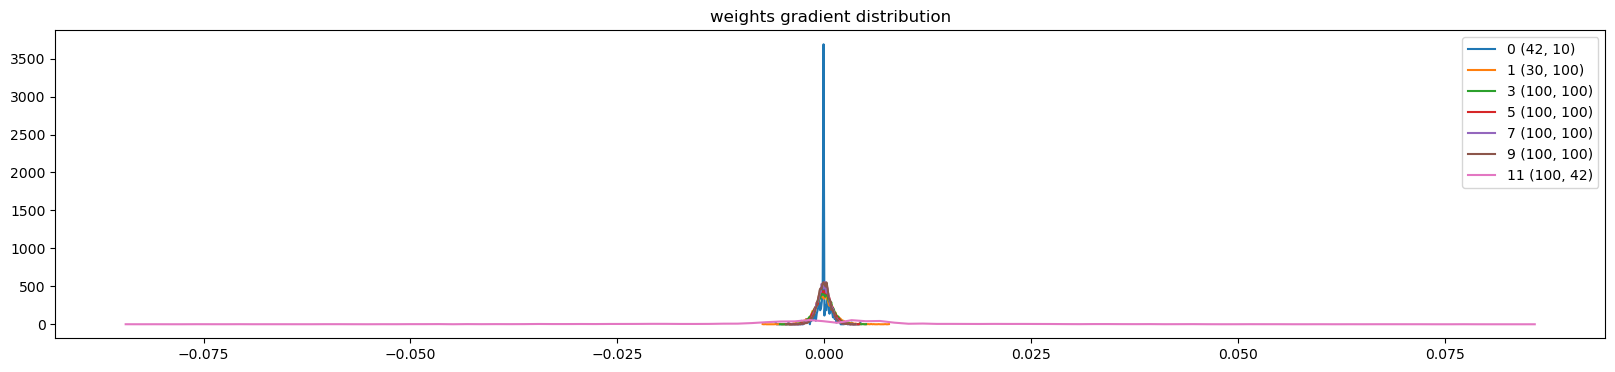

In [11]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # --------------------------------------------------------
            layer.weight *= (5/3)
            # --------------------------------------------------------

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: ir além dessa primeira iteração!

# --------------------------------------------------------
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        parameter_shape = tuple(p.shape)
        parameter_mean = p.grad.mean()
        parameter_std = p.grad.std()
        parameter_grad_to_data_std_ratio = p.grad.std() / p.std()
        
        print(f" Weight {str(parameter_shape):>10} |"
              f" mean: {parameter_mean:^10.6f} |"
              f" std: {parameter_std:^e} |"
              f" grad/data ratio: {parameter_grad_to_data_std_ratio:e}")
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

        plt.legend(legends)
plt.title('weights gradient distribution');
# --------------------------------------------------------

Os valores parecem razoavelmente estáveis e comparáveis, exceto pela última camada. Os gradientes da última camada são 10x maior do que nas outras, e razão entre os valores dos gradientes e dos dados é aproximadamente um. Isso tem a ver com a inicialização especial da última camada, mas por outro lado implica que, nessa primeira época, o aprendizado dessa camada é 10x mais rápido do que as outras.

Mesmo assim, não é um grande problema: se aumentarmos o número de iterações, vemos que as discrepâncias entre as camadas vão embora com o treinamento.

48162
      0/ 100000: 3.7339
 Weight   (42, 10) | mean:  0.000648  | std: 1.204603e-02 | grad/data ratio: 1.233006e-02
 Weight  (30, 100) | mean:  0.000199  | std: 1.331324e-02 | grad/data ratio: 4.335028e-02
 Weight (100, 100) | mean:  0.000153  | std: 9.994164e-03 | grad/data ratio: 5.837909e-02
 Weight (100, 100) | mean:  0.000037  | std: 9.374107e-03 | grad/data ratio: 5.569243e-02
 Weight (100, 100) | mean:  0.000023  | std: 8.058558e-03 | grad/data ratio: 4.721602e-02
 Weight (100, 100) | mean: -0.000040  | std: 6.399726e-03 | grad/data ratio: 3.785858e-02
 Weight  (100, 42) | mean:  0.000000  | std: 2.091437e-02 | grad/data ratio: 2.777136e-01


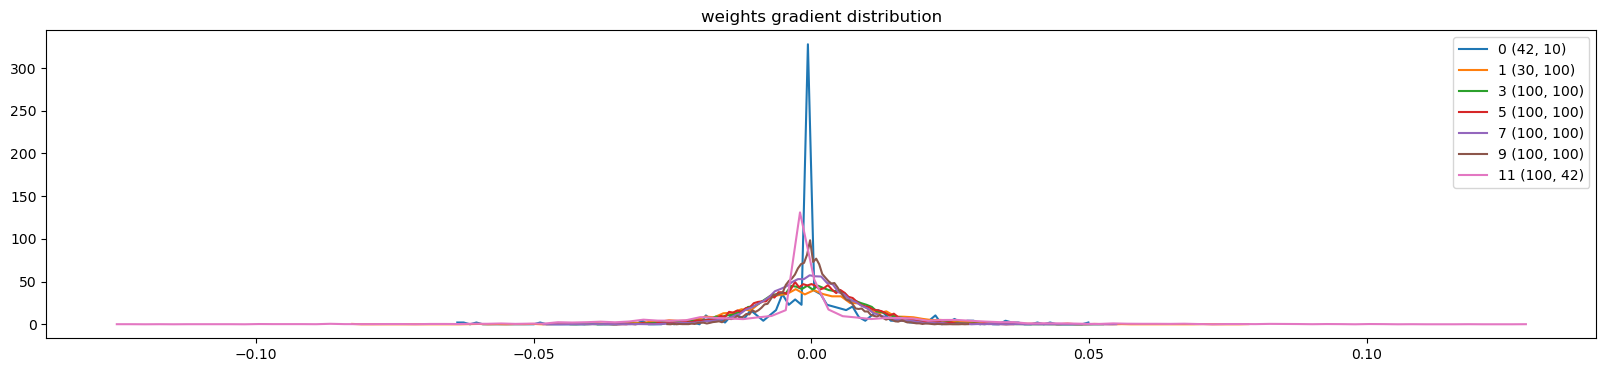

In [12]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # --------------------------------------------------------
            layer.weight *= (5/3)
            # --------------------------------------------------------

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # --------------------------------------------------------
    if i >= 1000:
        break # AFTER_DEBUG: ir além dessa primeira iteração!
    # --------------------------------------------------------

plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        parameter_shape = tuple(p.shape)
        parameter_mean = p.grad.mean()
        parameter_std = p.grad.std()
        parameter_grad_to_data_std_ratio = p.grad.std() / p.std()
        
        print(f" Weight {str(parameter_shape):>10} |"
              f" mean: {parameter_mean:^10.6f} |"
              f" std: {parameter_std:^e} |"
              f" grad/data ratio: {parameter_grad_to_data_std_ratio:e}")
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

        plt.legend(legends)
plt.title('weights gradient distribution');

## 4.4 Diagnóstico: update/parâmetros

Um diagnóstico importante é olhar para a razão entre o desvio-padrão dos updates (taxa de aprendizado vezes gradiente) numa camada e o desvio-padrão dos valores atuais dos parâmetros na mesma camada. A razão é que o passo de gradiente modificará os parâmetros justamente nessa escala.

48162
      0/ 100000: 3.7339


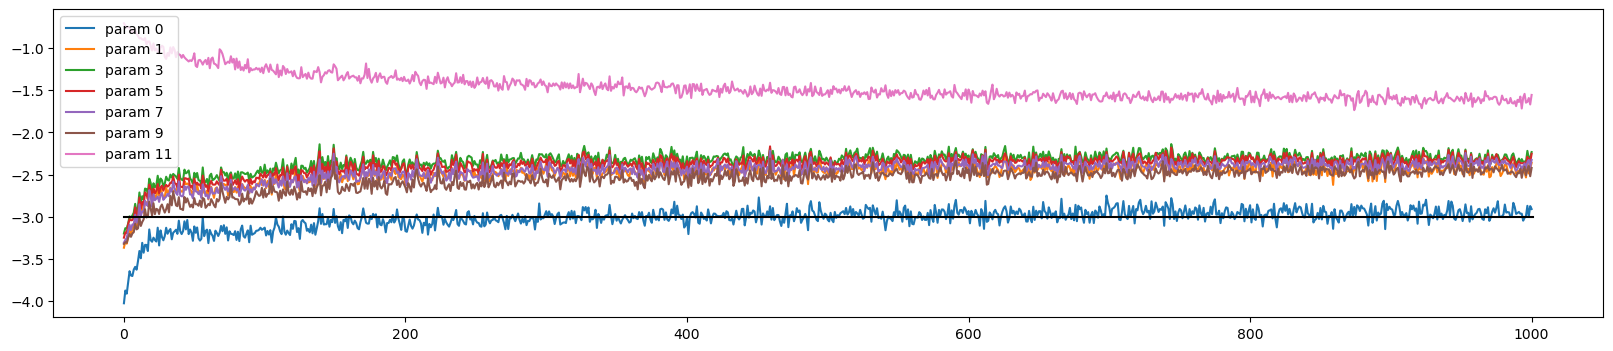

In [13]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []
# --------------------------------------------------------
ud = []
# --------------------------------------------------------

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # --------------------------------------------------------
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # --------------------------------------------------------

    if i >= 1000:
        break # AFTER_DEBUG: ir além dessas primeiras iterações!

# --------------------------------------------------------
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Valor ideal: 1e-3 (ou -3, na nossa escala log)
plt.legend(legends);
# --------------------------------------------------------

Acima temos, no eixo-x, as épocas, mostrando a evolução da razão entre o grau de variação dos updates e dos dados. Uma heurística razoável é que os updates tenham uma escala de algo como um milésimo da escala dos dados; essa é a linha preto no gráfico; se a razão fosse algo como -1 ou 0, os valores estariam mudando bastante com cada update e se fosse algo muito acima de -3 então os valores não estão sendo atualizados numa escala razoável para o aprendizado acontecer. Não há uma explicação matemática para o -3, mas é algo tipicamente observado em redes com um tuning bem feito.

Por exemplo, vamos ver como o gráfico muda com uma taxa de aprendizado muito pequena ou muito grande:

48162
      0/ 100000: 3.7339


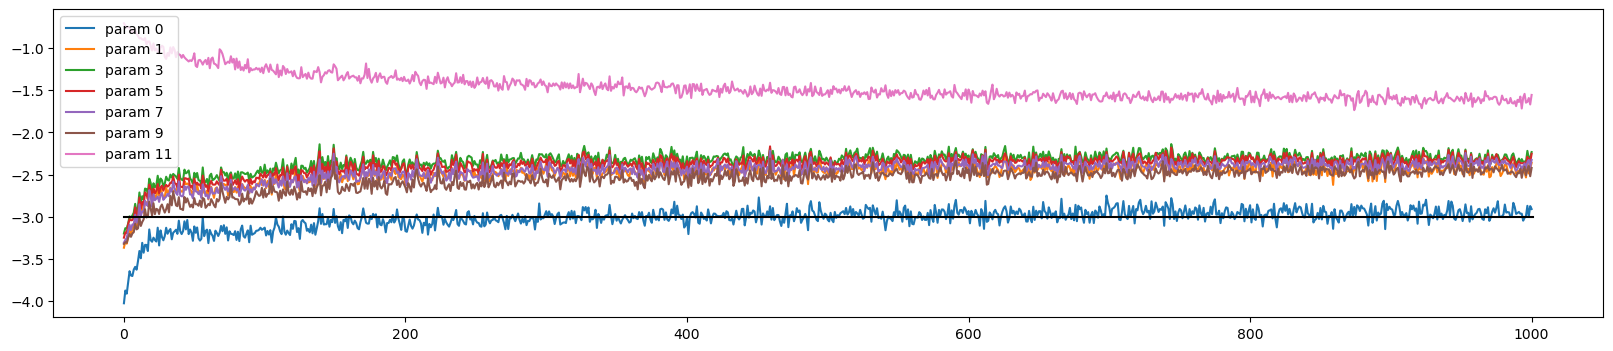

In [14]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    # --------------------------------------------------------
    lr = 0.1 # 0.0001 # 1 # 0.1 if i < 150000 else 0.01 # decaimento da taxa de aprendizado
    # --------------------------------------------------------

    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: ir além dessas primeiras iterações!

plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Valor ideal: 1e-3 (ou -3, na nossa escala log)
plt.legend(legends);

Esse diagnóstico é uma maneira útil de decidir qual é uma boa taxa de aprendizado.

## 4.5 Exemplo: usando os diagnósticos

De posse desses gráficos indicativos, vamos ver como uma rede levemente descalibrada seria acusada por esses diagnósticos. Por exemplo, vamos inicializar as camadas lineares sem normalizá-las por $(1/\sqrt{\text{fan}_{\text{in}}})$.

In [15]:
class Linear:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  
    def __init__(self, fan_in, fan_out, bias=True):
        
        # --------------------------------------------------------
        self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5
        # --------------------------------------------------------
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [16]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100 # número de neurônios em cada camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # função perda
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    # --------------------------------------------------------
    lr = 0.1 if i < 150000 else 0.01 # decaimento da taxa de aprendizado
    # --------------------------------------------------------

    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: ir além dessas primeiras iterações!

48162
      0/ 200000: 4.0530


Layer 1 (Tanh): mean 0.00, std 0.99, saturation 96.94%
Layer 3 (Tanh): mean 0.02, std 0.98, saturation 90.72%
Layer 5 (Tanh): mean -0.02, std 0.98, saturation 89.91%
Layer 7 (Tanh): mean 0.02, std 0.98, saturation 90.09%
Layer 9 (Tanh): mean 0.01, std 0.97, saturation 88.94%


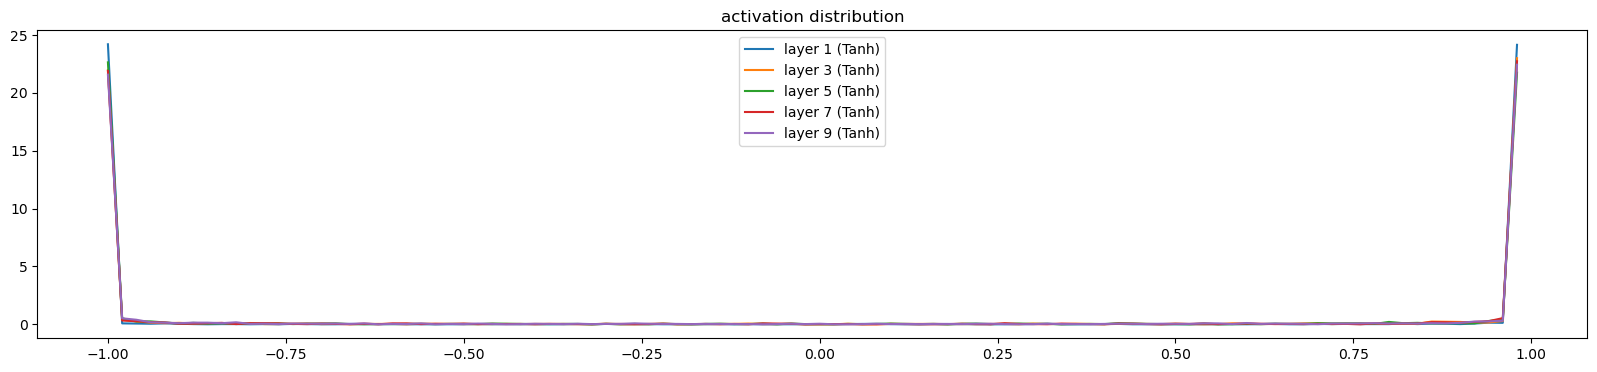

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
    
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.mean()
        layer_std = layer.out.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution');

Layer 1 (Tanh): mean 0.00, std 0.14, saturation 96.94%
Layer 3 (Tanh): mean -0.00, std 0.04, saturation 90.72%
Layer 5 (Tanh): mean -0.00, std 0.02, saturation 89.91%
Layer 7 (Tanh): mean 0.00, std 0.01, saturation 90.09%
Layer 9 (Tanh): mean -0.00, std 0.00, saturation 88.94%


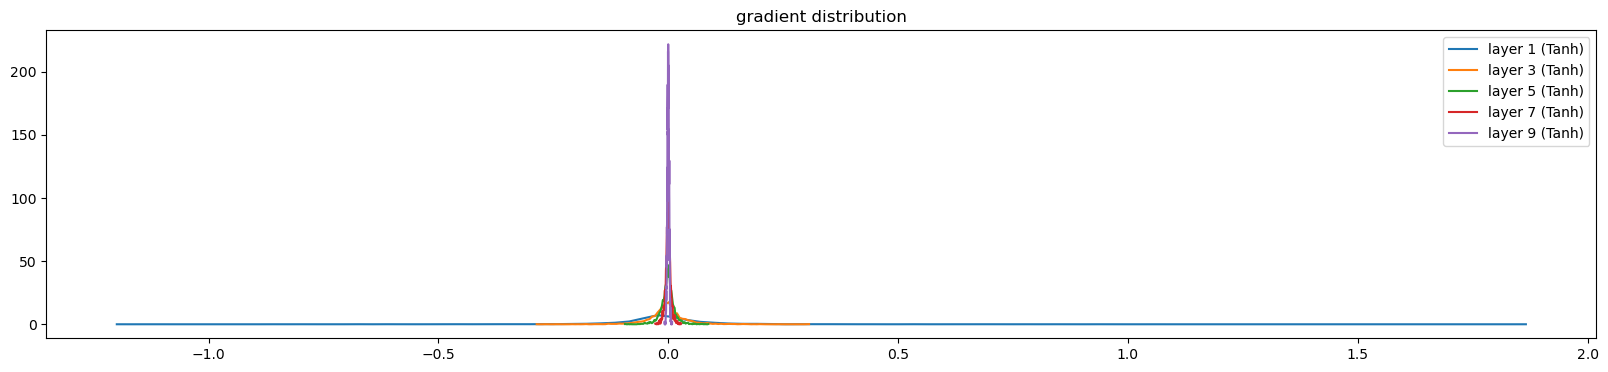

In [18]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.grad.mean()
        layer_std = layer.out.grad.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('gradient distribution');

 Weight   (42, 10) | mean:  0.044299  | std: 8.296897e-01 | grad/data ratio: 3.755734e-01
 Weight  (30, 100) | mean: -0.001236  | std: 5.861341e-01 | grad/data ratio: 2.993049e-01
 Weight (100, 100) | mean:  0.000034  | std: 4.611742e-02 | grad/data ratio: 2.723491e-02
 Weight (100, 100) | mean:  0.000024  | std: 1.498291e-02 | grad/data ratio: 9.049518e-03
 Weight (100, 100) | mean: -0.000029  | std: 5.009572e-03 | grad/data ratio: 2.982851e-03
 Weight (100, 100) | mean: -0.000001  | std: 2.033082e-03 | grad/data ratio: 1.221653e-03
 Weight  (100, 42) | mean: -0.000000  | std: 2.690473e-02 | grad/data ratio: 4.035828e-01


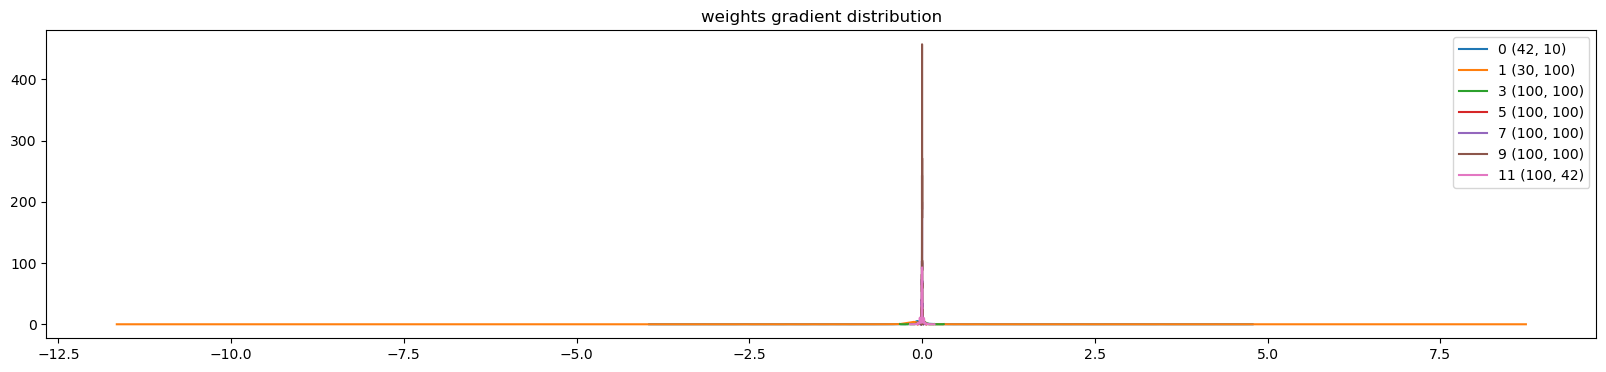

In [19]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        parameter_shape = tuple(p.shape)
        parameter_mean = p.grad.mean()
        parameter_std = p.grad.std()
        parameter_grad_to_data_std_ratio = p.grad.std() / p.std()
        
        print(f" Weight {str(parameter_shape):>10} |"
              f" mean: {parameter_mean:^10.6f} |"
              f" std: {parameter_std:^e} |"
              f" grad/data ratio: {parameter_grad_to_data_std_ratio:e}")
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

        plt.legend(legends)
plt.title('weights gradient distribution');

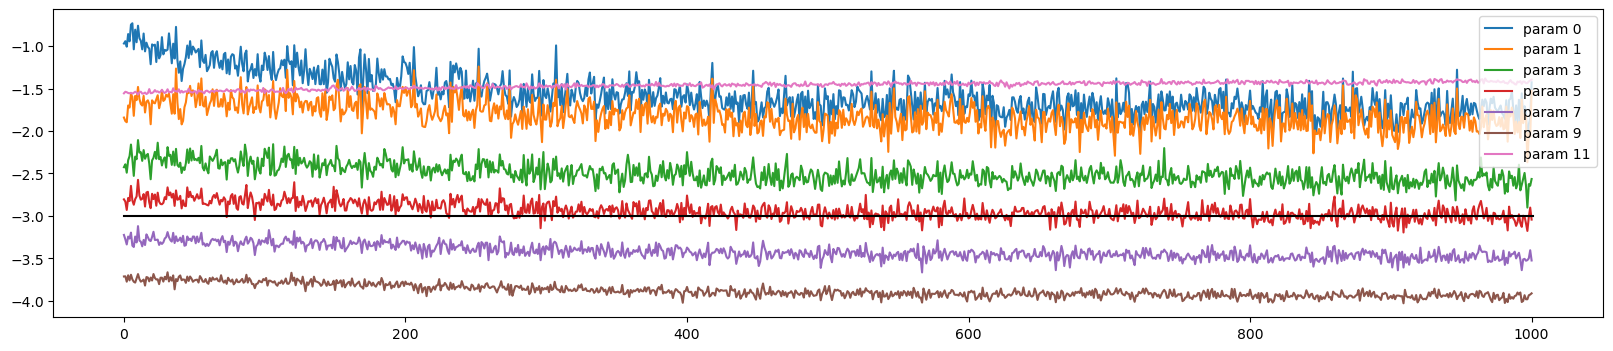

In [20]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Valor ideal: 1e-3 (ou -3, na nossa escala log)
plt.legend(legends);

Ou seja, esses diagnósticos de fato disparam quando a rede não está bem inicializada. Eles também chamam atenção para quão delicado pode ser treinar uma rede neural quando queremos usar múltiplas camadas e todas elas precisam aprender mais ou menos na mesma velocidade, sem que os gradientes explodam ou se dissipem.

## 4.6 Batchnorm!

Agora, vamos olhar para o impacto de incluir batchnorm antes de cada tanh. Esperaríamos que, através dos diagnósticos que desenvolvemos acima, seja possível ver o impacto imediato da normalização dessas camadas. Primeiro, vamos trazer de volta a inicialização correta da camada linear.

In [21]:
class Linear:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

Note que, pela inclusão de batchnorm, nós não mais precisamos de viés nas camadas lineares.

In [22]:
vocab_size = len(itos)
n_embd = 10
n_hidden = 100

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

# Agora, vamos usar vários blocos de camadas (linear + batchnorm + tanh):
C = torch.randn((vocab_size, n_embd),            generator=g)
# ----------------------------------------------------------------------------------
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# ----------------------------------------------------------------------------------

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # 0.5 # 5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: ir além dessa primeira iteração!

      0/ 100000: 3.7245


Layer 2 (Tanh): mean -0.00, std 0.63, saturation 2.56%
Layer 5 (Tanh): mean 0.00, std 0.64, saturation 2.09%
Layer 8 (Tanh): mean -0.00, std 0.64, saturation 2.16%
Layer 11 (Tanh): mean -0.00, std 0.64, saturation 2.31%
Layer 14 (Tanh): mean 0.01, std 0.64, saturation 2.59%


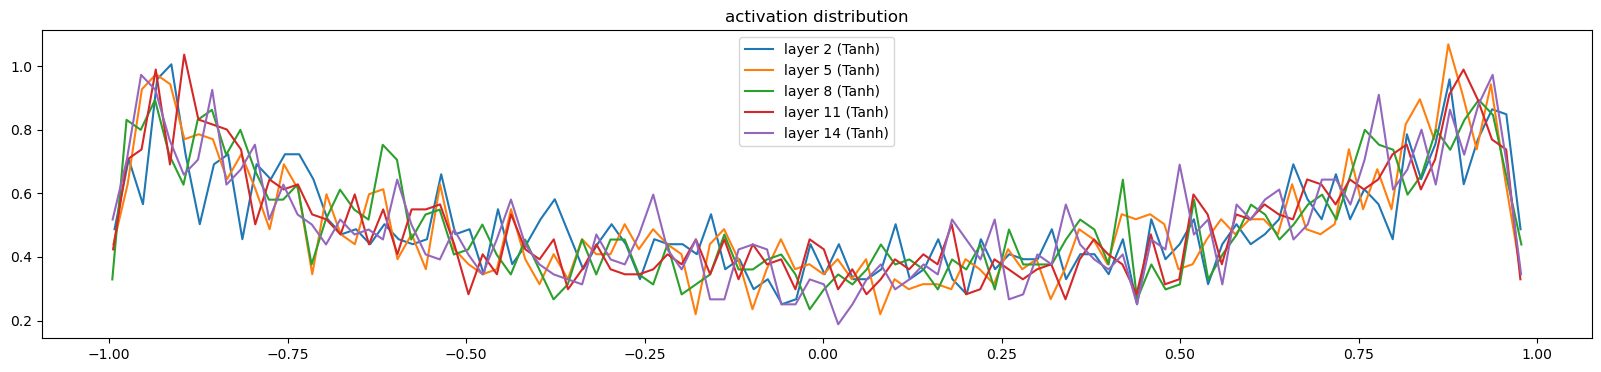

In [23]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
    
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.mean()
        layer_std = layer.out.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution');

Layer 2 (Tanh): mean 0.00, std 0.00, saturation 2.56%
Layer 5 (Tanh): mean 0.00, std 0.00, saturation 2.09%
Layer 8 (Tanh): mean 0.00, std 0.00, saturation 2.16%
Layer 11 (Tanh): mean -0.00, std 0.00, saturation 2.31%
Layer 14 (Tanh): mean 0.00, std 0.00, saturation 2.59%


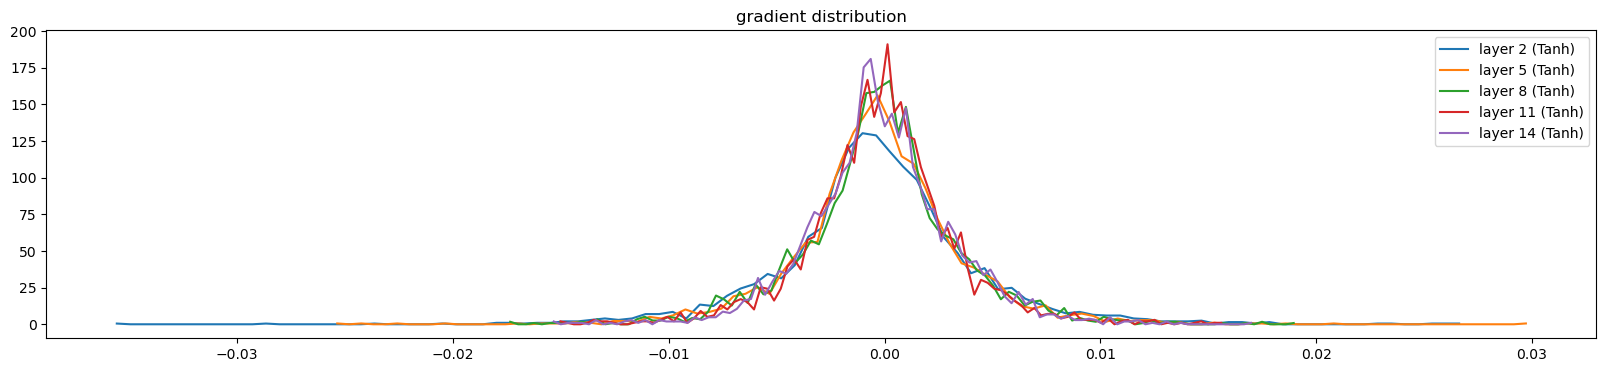

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.grad.mean()
        layer_std = layer.out.grad.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('gradient distribution');

 Weight   (42, 10) | mean: -0.000000  | std: 1.076766e-02 | grad/data ratio: 1.101441e-02
 Weight  (30, 100) | mean:  0.000340  | std: 1.105325e-02 | grad/data ratio: 3.601344e-02
 Weight (100, 100) | mean: -0.000000  | std: 8.908320e-03 | grad/data ratio: 5.244154e-02
 Weight (100, 100) | mean:  0.000038  | std: 7.733390e-03 | grad/data ratio: 4.638453e-02
 Weight (100, 100) | mean: -0.000026  | std: 7.103649e-03 | grad/data ratio: 4.205056e-02
 Weight (100, 100) | mean:  0.000037  | std: 6.831486e-03 | grad/data ratio: 4.080343e-02
 Weight  (100, 42) | mean: -0.000033  | std: 1.041530e-02 | grad/data ratio: 6.339974e-02


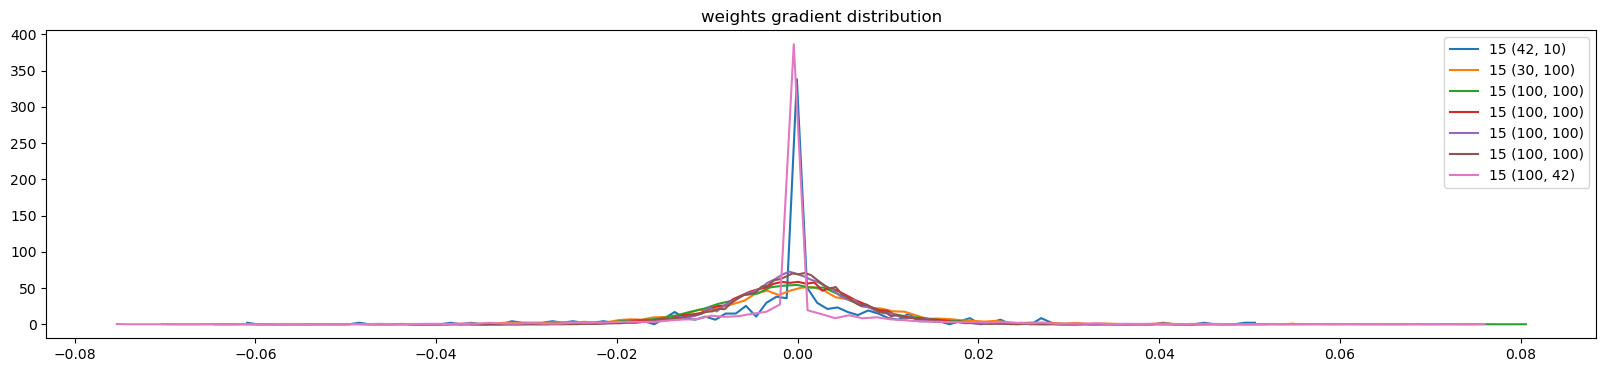

In [25]:
plt.figure(figsize=(20, 4))
legends = []

for p in parameters:
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        parameter_shape = tuple(p.shape)
        parameter_mean = p.grad.mean()
        parameter_std = p.grad.std()
        parameter_grad_to_data_std_ratio = p.grad.std() / p.std()
        
        print(f" Weight {str(parameter_shape):>10} |"
              f" mean: {parameter_mean:^10.6f} |"
              f" std: {parameter_std:^e} |"
              f" grad/data ratio: {parameter_grad_to_data_std_ratio:e}")
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

        plt.legend(legends)
plt.title('weights gradient distribution');

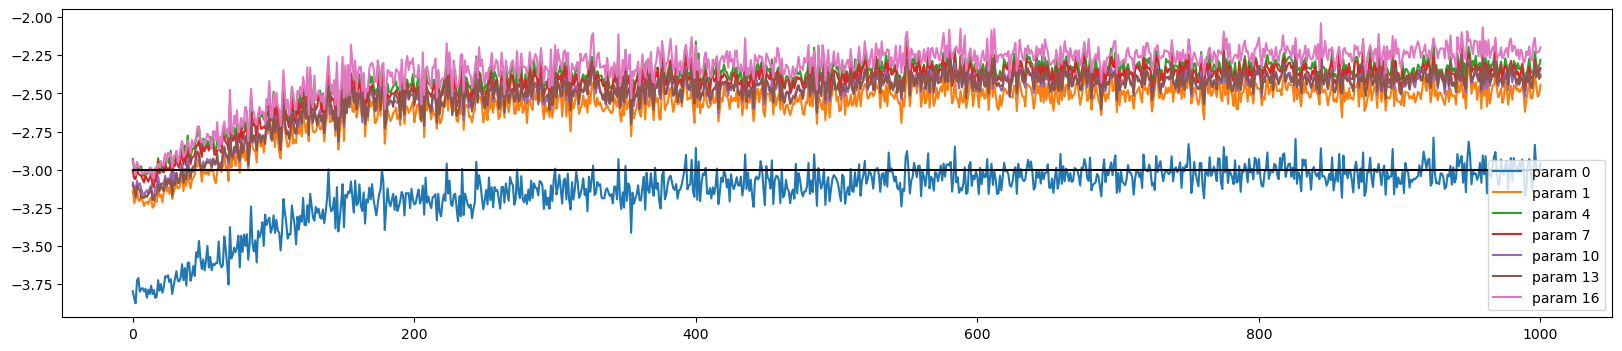

In [26]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Valor ideal: 1e-3 (ou -3, na nossa escala log)
plt.legend(legends);

E a vantagem de batchnorm é que mesmo que não inicializemos `layer.weight *= 5/3` ainda assim a rede permaneceria balanceada (por exemplo, veja o que acontece com `layer.weight *= 0.5` ou `layer.weight *= 5`).

Como exemplo da estabilidade que batchnorm nos confere, vamos retirar o `fan_in` na inicialização da camada linear e ver o resultado.

In [27]:
class Linear:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  
    def __init__(self, fan_in, fan_out, bias=True):
        # ------------------------------------------------------------------------
        self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5
        # ------------------------------------------------------------------------
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

vocab_size = len(itos)
n_embd = 10
n_hidden = 100

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

# Agora, vamos usar vários blocos de camadas (linear + batchnorm + tanh):
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: ir além dessa primeira iteração!

      0/ 100000: 3.7245


Layer 2 (Tanh): mean 0.00, std 0.63, saturation 2.56%
Layer 5 (Tanh): mean 0.00, std 0.64, saturation 2.44%
Layer 8 (Tanh): mean 0.00, std 0.64, saturation 2.62%
Layer 11 (Tanh): mean 0.00, std 0.63, saturation 2.69%
Layer 14 (Tanh): mean 0.01, std 0.64, saturation 2.69%


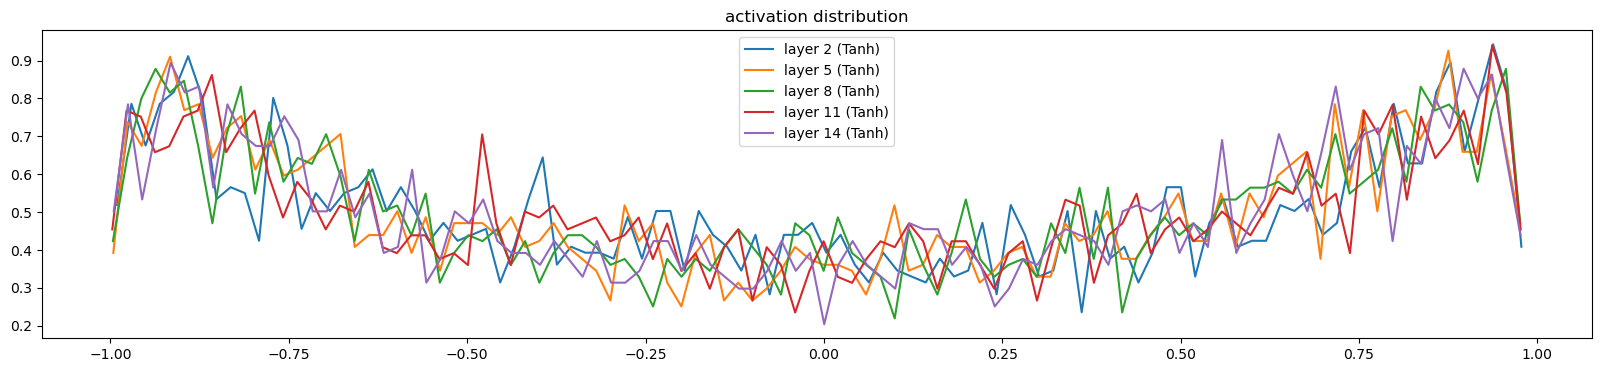

In [28]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
    
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.mean()
        layer_std = layer.out.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution');

Layer 2 (Tanh): mean 0.00, std 0.00, saturation 2.56%
Layer 5 (Tanh): mean 0.00, std 0.00, saturation 2.44%
Layer 8 (Tanh): mean -0.00, std 0.00, saturation 2.62%
Layer 11 (Tanh): mean 0.00, std 0.00, saturation 2.69%
Layer 14 (Tanh): mean 0.00, std 0.00, saturation 2.69%


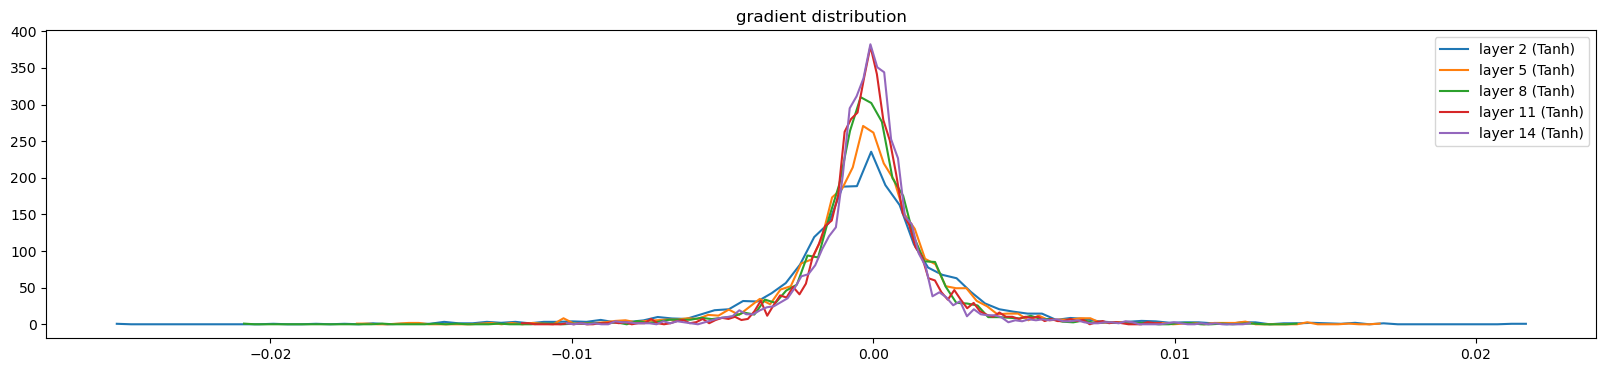

In [29]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluindo a última camada

    if isinstance(layer, Tanh):
        layer_name = layer.__class__.__name__
        layer_mean = layer.out.grad.mean()
        layer_std = layer.out.grad.std()
        layer_saturation = (layer.out.abs() > 0.97).float().mean()*100
        
        print(f"Layer {i} ({layer_name}): "
              f"mean {layer_mean:.2f}, "
              f"std {layer_std:.2f}, "
              f"saturation {layer_saturation:.2f}%")
        hy, hx = torch.histogram(layer.out.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('gradient distribution');

 Weight   (42, 10) | mean:  0.000000  | std: 6.250771e-03 | grad/data ratio: 6.395614e-03
 Weight  (30, 100) | mean:  0.000016  | std: 1.423837e-03 | grad/data ratio: 8.504889e-04
 Weight (100, 100) | mean: -0.000002  | std: 6.361487e-04 | grad/data ratio: 3.778994e-04
 Weight (100, 100) | mean: -0.000003  | std: 5.264067e-04 | grad/data ratio: 3.181743e-04
 Weight (100, 100) | mean: -0.000002  | std: 4.289840e-04 | grad/data ratio: 2.554441e-04
 Weight (100, 100) | mean:  0.000002  | std: 4.056082e-04 | grad/data ratio: 2.437162e-04
 Weight  (100, 42) | mean: -0.000007  | std: 5.232670e-04 | grad/data ratio: 3.227344e-04


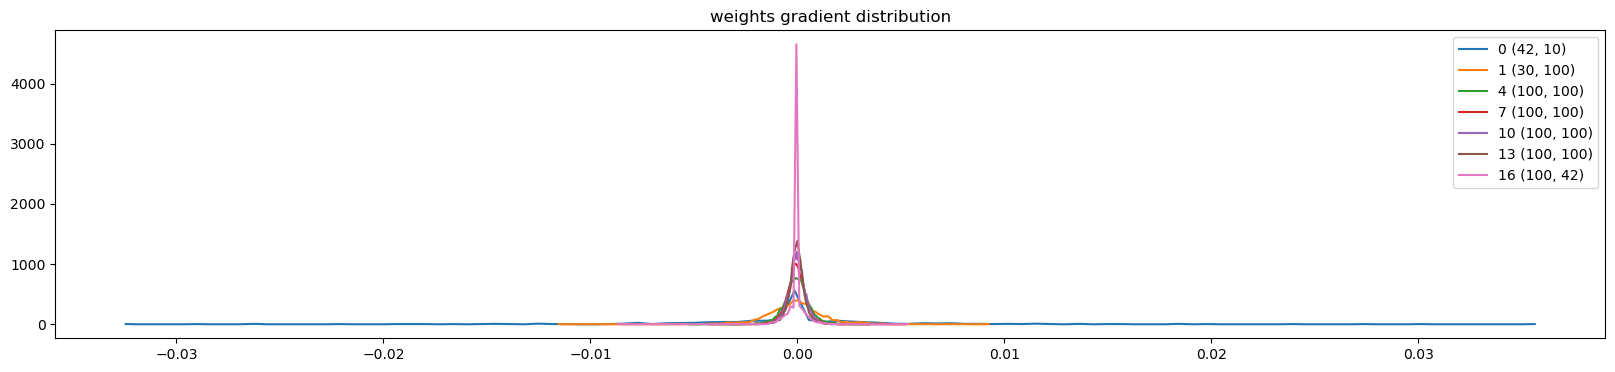

In [30]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        parameter_shape = tuple(p.shape)
        parameter_mean = p.grad.mean()
        parameter_std = p.grad.std()
        parameter_grad_to_data_std_ratio = p.grad.std() / p.std()
        
        print(f" Weight {str(parameter_shape):>10} |"
              f" mean: {parameter_mean:^10.6f} |"
              f" std: {parameter_std:^e} |"
              f" grad/data ratio: {parameter_grad_to_data_std_ratio:e}")
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

        plt.legend(legends)
plt.title('weights gradient distribution');

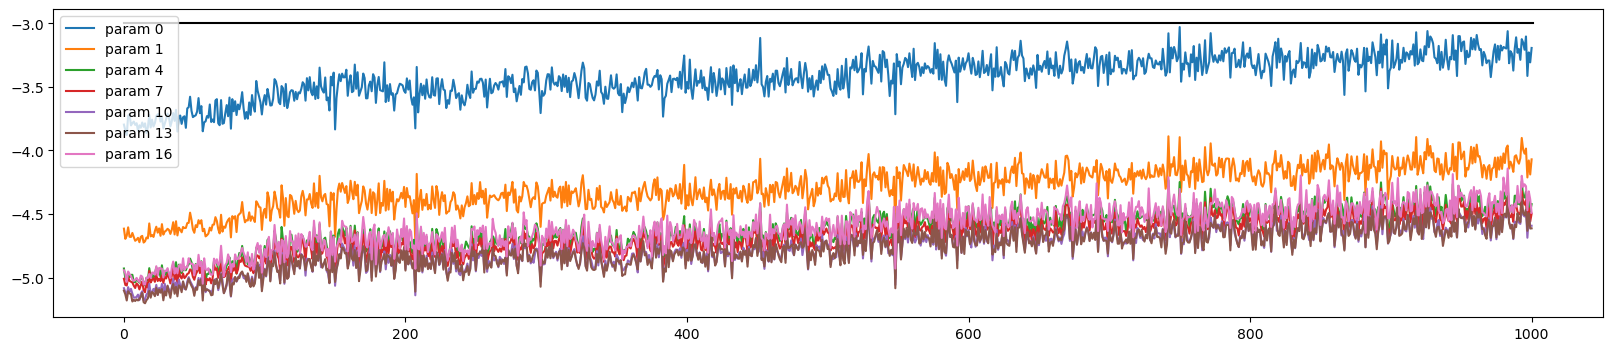

In [31]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Valor ideal: 1e-3 (ou -3, na nossa escala log)
plt.legend(legends);

Todos os gráficos parecem ok, exceto esse último: é possível que a taxa de aprendizado sofra alguma alteração por conta da escala dos dados. Mesmo assim, pelo menos conseguimos corrigir o problema de maneira simples, através de um único parâmetro, ao invés de ter que reconsiderar a arquitetura da rede inteira e da maneira como ativações e gradientes interagem.

O último gráfico sugere que um aumento de 10x na taxa de aprendizado pode ajudar a estabilizar a razão update/parâmetros. Vamos ver o que acontece.

      0/ 100000: 3.7245


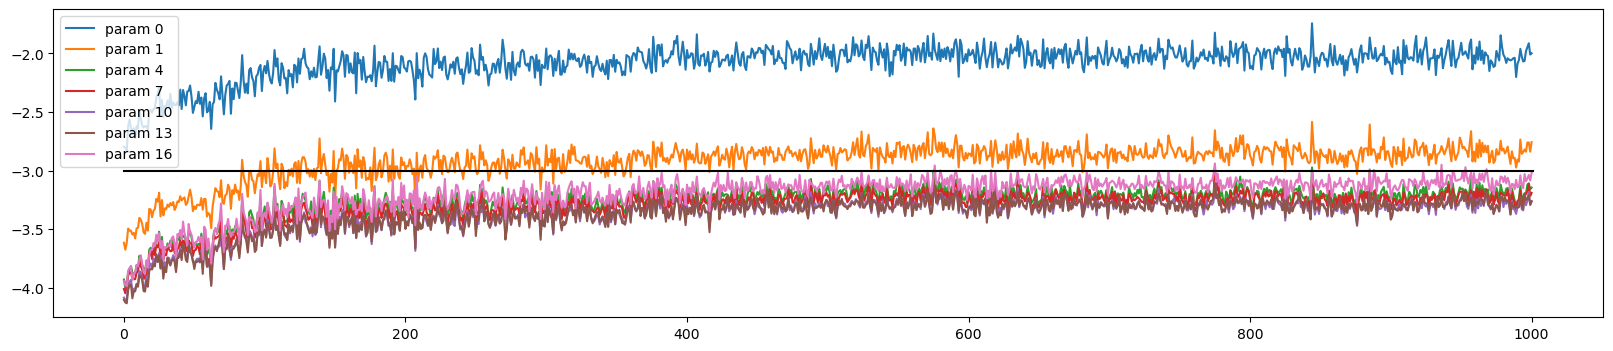

In [32]:
class Linear:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  
    def __init__(self, fan_in, fan_out, bias=True):
        # ------------------------------------------------------------------------
        self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5
        # ------------------------------------------------------------------------
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

vocab_size = len(itos)
n_embd = 10
n_hidden = 100

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

# Agora, vamos usar vários blocos de camadas (linear + batchnorm + tanh):
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: retirar retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    # ------------------------------------------------------------------------
    lr = 1
    # ------------------------------------------------------------------------
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: ir além dessa primeira iteração!

plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:  # Apenas as matrizes W; não os viéses b e parâmetros de batchnorm gamma, beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Valor ideal: 1e-3 (ou -3, na nossa escala log)
plt.legend(legends);

## 4.7 Resultado final com 200.000 épocas

Vamos analisar o resultado final da nossa rede com 6 blocos de camadas (lineares+batchnorm+tanh). Note que pela quantidade de parâmetros (47 mil) que agora estamos treinando e épocas (200 mil) é provável que esse código leve alguns minutos para rodar.

In [ ]:
class Linear:
    # Compare com https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

vocab_size = len(itos)
n_embd = 10
n_hidden = 100

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)

# Agora, vamos usar vários blocos de camadas (linear + batchnorm + tanh):
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):  # 5m
  
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

      0/ 200000: 3.7245
  10000/ 200000: 1.7443


In [ ]:
# # put layers into eval mode
# for layer in layers:
#     layer.training = False
# split_loss('train')
# split_loss('val')

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def generate(seed=0):
    for layer in layers:
        layer.training = False
    
    torch.manual_seed(seed)
    g = torch.Generator().manual_seed(seed)
    out = []
    context = [0] * block_size
    for i in range(200):
        emb = C[torch.tensor([context])] # embedding
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x    
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
    print(''.join(itos[i] for i in out))

In [ ]:
generate(10)

In [ ]:
# pareste sante. todavia que em um bem, pai crite ou conto do peti e, anos olhos do dos carte. ago dos, que é as dia declavra divilo feriam os depois incor que ou corrias, a invantimou que hienos um bem

Estamos chengando mais perto do português!

Uma vantagem adicional do trabalho que fizemos acima é que a implementação das camadas em PyTorch é praticamente igual a que elaboramos acima (mas a versão do PyTorch é mais rápida e otimizada). Ou seja, as opções abaixo são equivalentes: 

In [ ]:
import torch.nn as nn

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

layers = [
    nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(           n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(           n_hidden, vocab_size, bias=False), nn.BatchNorm1d(vocab_size),
]

Isso vai nos permitir começar a usar o PyTorch sem fricção alguma!